# Reading and combining data

In [1]:
import h5py
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import coo_matrix, hstack, vstack, issparse

def read_brain_atlas_data(filename):
    h5 = h5py.File(filename, 'r')
    print('reading chunks')
    countdata = h5['data']['counts']
    nrows, ncols = countdata.shape
    sparsechunks, sparsecolchunks = [], []
    for rowslice, colslice in countdata.iter_chunks():
        sparsechunk = coo_matrix(
            countdata[rowslice, colslice].T.astype(np.int32),
        )
        sparsechunk.eliminate_zeros()
        sparsechunks.append(
            sparsechunk
        )
        
        if colslice.stop == ncols:
            sparsecolchunks.append(
                vstack(sparsechunks)
            )
            
            del sparsechunks
            sparsechunks = []
    
    print('stack column chunks')
    X = hstack(sparsecolchunks)
    del sparsecolchunks
    
    print('convert to csr matrix')
    X = X.tocsr()
    
    row_col = dict()
    for h5key, dictkey in zip(['gene', 'samples'], ['var', 'obs']):
        print(f'reading {h5key}')
        row_col[dictkey] = pd.DataFrame(
            index = np.char.decode(
                h5['data'][h5key][()],
                encoding = 'utf-8'
            )
        )
    
    print('converting to AnnData')
    return ad.AnnData(X, **row_col)

In [7]:
# this takes approximately 200GB of RAM due to the count matrix being saved as dense array
# adata = read_brain_atlas_data('../data/mouse_brain_adult_counts.h5')
# adata.obs.index = adata.obs.index.str.replace('10X_cells.', '', regex = True)
# metadata = pd.read_csv(
#     '../data/mouse_brain_adult_anno.csv',
#     index_col = 0
# )
# metadata.index = metadata.sample_name.str.replace('10X_cells.', '', regex = True).to_list()
# metadata.drop(
#     columns = [
#         'sample_name',
#         'exp_component_name'
#     ]
# )
# adata.obs = adata.obs.merge(
#     metadata,
#     left_index = True,
#     right_index = True,
#     how = 'left'
# )
# adata.write_h5ad('../data/mouse_brain_adult.h5ad')

In [3]:
# only using primary somatosensory cortex (SSp)
adata = sc.read_h5ad(
    '../data/mouse_brain_adult.h5ad'
)
adult = adata[adata.obs.region_label == 'SSp', :].copy()
del adata

In [4]:
metadata = pd.read_csv(
    '../data/metaData_scDevSC.txt',
    sep = '\t',
    skiprows = [1]
)
metadata.index = metadata.NAME.to_list()
metadata.drop(
    columns = ['NAME'],
    inplace = True
)
metadata

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,...,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
E10_v1_AAACCTGAGGGTCTCC-1,E10,1544,1022,0.020078,51,0.356987,0.330795,S,0.026192,34,...,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACAACGCC-1,E10,1157,783,0.014693,39,0.453854,0.260560,S,0.193294,34,...,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACGACGAA-1,E10,2081,1200,0.016338,67,0.447598,0.218746,S,0.228852,34,...,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGACAAGC-1,E10,2490,1430,0.021285,71,0.227723,0.307102,G2M,-0.079379,37,...,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGAGCCAA-1,E10,2514,1416,0.021082,70,0.738406,0.136556,S,0.601850,37,...,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P4_TTTGTCAGTTGATTGC-1,P4,8028,3130,0.064275,74,-0.225020,-0.244369,G1,0.019349,16,...,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_TTTGTCATCAACGGCC-1,P4,15768,4425,0.041540,79,-0.219746,-0.236435,G1,0.016689,24,...,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_TTTGTCATCCGTTGTC-1,P4,21692,4931,0.041398,76,-0.207196,-0.244800,G1,0.037604,16,...,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_TTTGTCATCGATGAGG-1,P4,3680,1897,0.057880,67,-0.185044,-0.185335,G1,0.000291,16,...,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


In [112]:
e14_5 = sc.read_10x_h5('../data/mouse_brain_E14_5.h5')
e14_5.var_names_make_unique()
print(e14_5)
e14_5_metadata = metadata[metadata.index.str.startswith('E14')]
e14_5_metadata.index = e14_5_metadata.index.str.replace('E14_5_', '')
e14_5_metadata.index = [i + '-1' for i in e14_5_metadata.index]
e14_5.obs = e14_5.obs.merge(
    e14_5_metadata,
    left_index = True,
    right_index = True,
    how = 'left'
)
e14_5 = e14_5[~e14_5.obs.isna().all(axis = 1), :].copy()
e14_5

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3485 × 27998
    var: 'gene_ids'


AnnData object with n_obs × n_vars = 3339 × 27998
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'n_hkgene', 'S_Score', 'G2M_Score', 'Phase', 'CC_Difference', 'seurat_clusters', 'RNA_snn_res_1', 'scrublet_doublet', 'RNA_snn_res_2', 'Doublet_intersect', 'Gral_cellType', 'New_cellType', 'biosample_id', 'donor_id', 'species', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'species__ontology_label'
    var: 'gene_ids'

In [113]:
p4 = sc.read_10x_h5('../data/mouse_brain_P4.h5')
p4.var_names_make_unique()
print(p4)
p4_metadata = metadata[metadata.index.str.startswith('P4')]
p4_metadata.index = p4_metadata.index.str.replace('P4_', '')
p4_metadata
p4.obs = p4.obs.merge(
    p4_metadata,
    left_index = True,
    right_index = True,
    how = 'left'
)
p4 = p4[~p4.obs.isna().all(axis = 1), :].copy()
p4

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6480 × 27998
    var: 'gene_ids'


AnnData object with n_obs × n_vars = 6367 × 27998
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'n_hkgene', 'S_Score', 'G2M_Score', 'Phase', 'CC_Difference', 'seurat_clusters', 'RNA_snn_res_1', 'scrublet_doublet', 'RNA_snn_res_2', 'Doublet_intersect', 'Gral_cellType', 'New_cellType', 'biosample_id', 'donor_id', 'species', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'species__ontology_label'
    var: 'gene_ids'

In [34]:
common_genes = set(adult.var.index).intersection(
    set(p4.var.index)
)
len(common_genes)

26589

In [55]:
e14_5 = e14_5[:, e14_5.var.index.isin(common_genes)].copy()
p4 = p4[:, p4.var.index.isin(common_genes)].copy()
adult = adult[:, adult.var.index.isin(common_genes)].copy()

In [9]:
cell_grouping = pd.read_excel(
    '../meta/scRNASeq_datasets_wt_groups.xlsx', 
    sheet_name = None
)
cell_grouping

{'Allen_Brain_Atlas_IN':       class_label subclass_label  subclass_id
 0       GABAergic           Sncg            4
 1       GABAergic          Lamp5            3
 2       GABAergic          Lamp5            3
 3       GABAergic          Lamp5            3
 4       GABAergic          Lamp5            3
 ..            ...            ...          ...
 370  Non-Neuronal          Oligo           37
 371  Non-Neuronal          Oligo           37
 372  Non-Neuronal          Astro           38
 373  Non-Neuronal          Astro           38
 374  Non-Neuronal          Astro           38
 
 [375 rows x 3 columns],
 'Allen_Brain_Atlas_OUT':       class_label subclass_label  subclass_id
 0   Glutamatergic             CR            1
 1       GABAergic          Meis2            2
 2       GABAergic          Meis2            2
 3    Non-Neuronal           Endo           39
 4    Non-Neuronal       SMC-Peri           40
 5    Non-Neuronal       SMC-Peri           40
 6    Non-Neuronal       SMC-Pe

In [115]:
# remove cells
rem_cellids = cell_grouping['Di_Bella_OUT'].subclass_label.str.strip().str.lower().to_list() + ['low quality cells', 'doublet', 'cajal retzius cells']

e14_5 = e14_5[~e14_5.obs.New_cellType.str.lower().isin(rem_cellids)].copy()
p4 = p4[~p4.obs.New_cellType.str.lower().isin(rem_cellids)].copy()

In [117]:
# annotate class labels
group_assignment = {
    row['subclass_label'].strip().lower(): row['class_label'].strip() for i, row in cell_grouping['Di_Bella_IN'].iterrows()
}
group_assignment['astrocytes'] = 'Non-Neuronal'
group_assignment['dl_cpn_1'] = 'Mature Glutamatergic'
group_assignment['dl_cpn_2'] = 'Mature Glutamatergic'
group_assignment['oligodendrocytes'] = 'Non-Neuronal'
group_assignment['layer 4'] = 'Mature Glutamatergic'
group_assignment['ul cpn'] = 'Mature Glutamatergic'
group_assignment['cycling glial cells'] = 'Non-Neuronal'
group_assignment['layer 6b'] = 'Mature Glutamatergic'

e14_5.obs['class_label'] = e14_5.obs.New_cellType.str.lower().apply(
    lambda x: group_assignment[x]
)
p4.obs['class_label'] = p4.obs.New_cellType.str.lower().apply(
    lambda x: group_assignment[x]
)

In [77]:
# remove cells; adult does not need to be relabelled since it already contains this labelling so only removal is done here
rem_cellids = cell_grouping['Allen_Brain_Atlas_OUT'].subclass_label.str.strip().str.lower().unique()
adult = adult[~adult.obs.subclass_label.str.lower().isin(rem_cellids), :].copy()

In [97]:
keep_adult = ['class_label', 'subclass_label']
adult.obs = adult.obs.loc[:, keep_adult]

In [118]:
for adata in [e14_5, p4]:
    adata.obs = adata.obs.loc[:, ['class_label', 'New_cellType']]
    adata.obs.rename(
        columns = {
            'New_cellType': 'subclass_label'
        },
        inplace = True
    )

In [106]:
# relabel Glutamateric to Mature Glutamatergic to comply to labelling of dev data
adult.obs.loc[:, 'class_label'] = adult.obs.class_label.apply(
    lambda x: 'Mature ' + x if x == 'Glutamatergic' else x
)

In [121]:
# combine and write to file
for adata, ident in zip([e14_5, p4, adult], ['E14.5', 'P4', 'Adult']):
    adata.obs.index = [ident + '_' + i for i in adata.obs.index]
    adata.obs['developmental_stage'] = ident
    
adata = ad.concat(
    [e14_5, p4, adult]
)
adata.write_h5ad('../data/mouse_brain_development.h5ad')

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'class_label' as categorical
/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclass_label' as categorical
/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and w

# Inspection

In [2]:
adata = sc.read_h5ad(
    '../data/mouse_brain_development.h5ad'
)
adata.obs.groupby(['class_label', 'developmental_stage']).count()

subclass_label
class_label            developmental_stage                
GABAergic              Adult                          4053
                       E14.5                           119
                       P4                              882
Immature Glutamatergic Adult                             0
                       E14.5                          1284
                       P4                              912
Mature Glutamatergic   Adult                         74263
                       E14.5                           632
                       P4                             3340
Non-Neuronal           Adult                          2199
                       E14.5                             0
                       P4                             1089
Progenitors            Adult                             0
                       E14.5                          1058
                       P4                                0

In [3]:
adata.layers['counts'] = adata.X.astype(int).copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [4]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    layer = 'counts',
    flavor = 'seurat_v3',
    subset = True
)

In [5]:
sc.pp.pca(
    adata, 
    n_comps = 40, 
    svd_solver = 'arpack',
    use_highly_variable = True,
)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

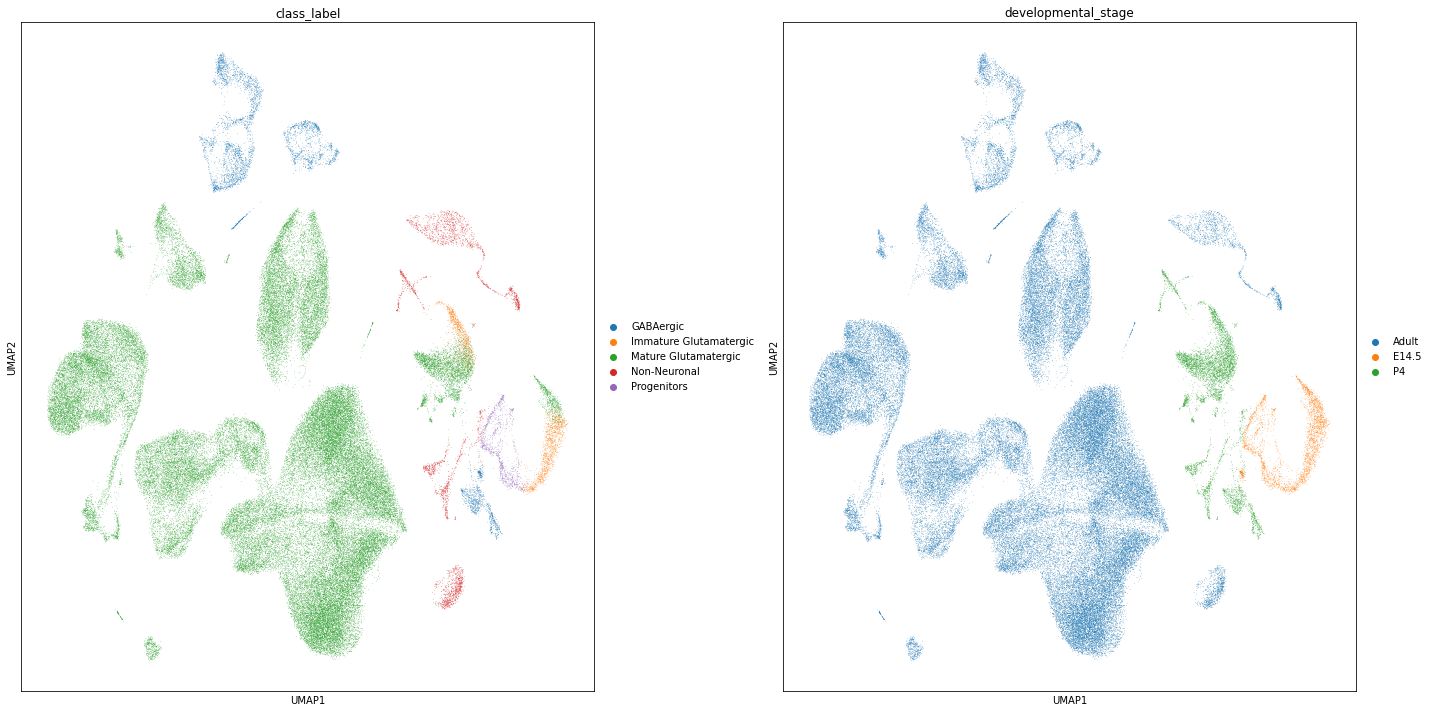

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
keys = ['class_label', 'developmental_stage']
for key, ax in zip(keys, axs):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [5]:
import scvi
scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    batch_key = 'developmental_stage'
   # continuous_covariate_keys = ['percent_mt', 'percent_ribo']
)

Global seed set to 0


INFO     Using batches from adata.obs["developmental_stage"]                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 89831 cells, 2000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [6]:
model = scvi.model.SCVI(adata)

In [7]:
model.train(use_gpu = True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 89/89: 100%|██████████| 89/89 [07:04<00:00,  4.77s/it, loss=920, v_num=1]   


In [8]:
adata.obsm['X_scvi'] = model.get_latent_representation()
adata.layers["scvi"] = model.get_normalized_expression(
    library_size=10e4
)

In [ ]:
sc.pp.neighbors(
    adata, 
    use_rep="X_scvi"
)
sc.tl.umap(adata)

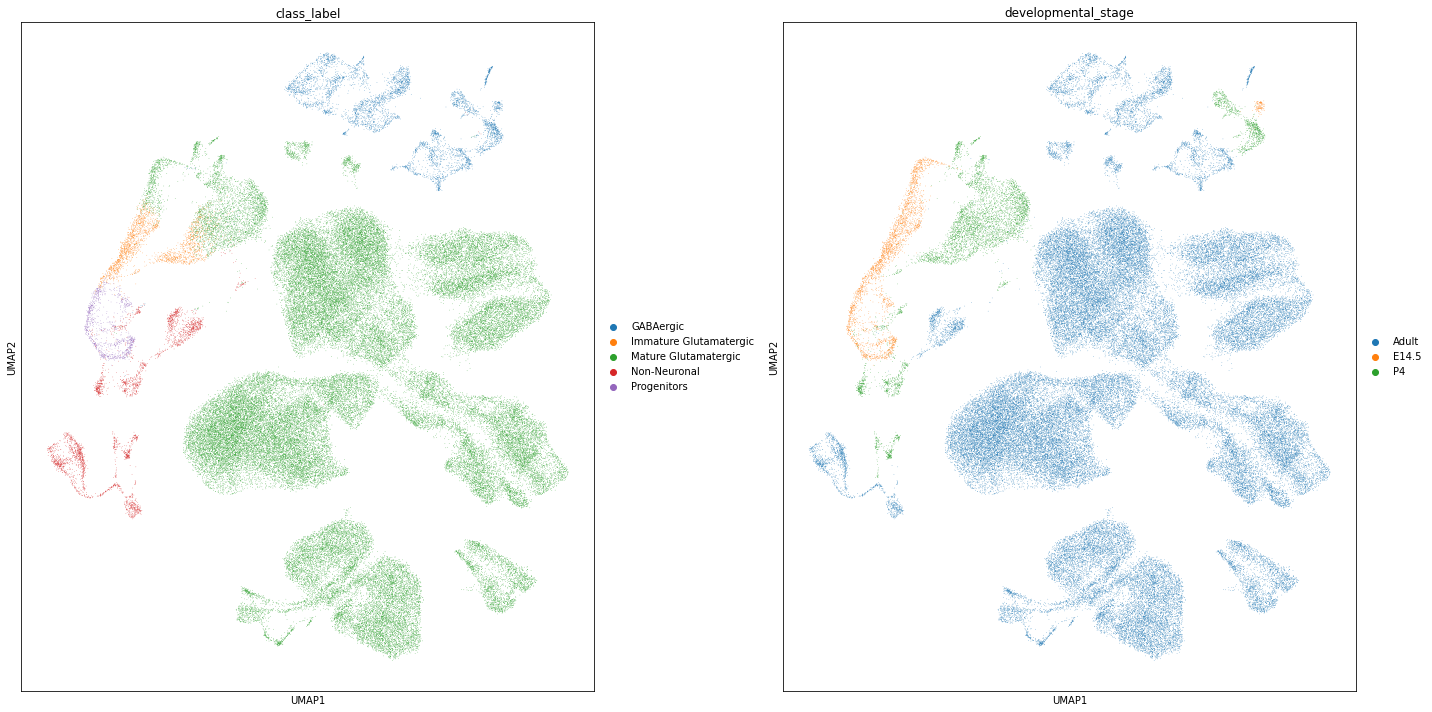

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
keys = ['class_label', 'developmental_stage']
for key, ax in zip(keys, axs):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [12]:
adata.write_h5ad(
    '../data/mouse_brain_development.integrated.h5ad'
)

In [13]:
model.save('../data/mouse_brain_development.scvi.model')